In [ ]:
import kagglehub
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, silhouette_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans, DBSCAN


dt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv')

In [ ]:
dt.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
dt.shape

(5110, 12)

In [ ]:
dt.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
dt.isna().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


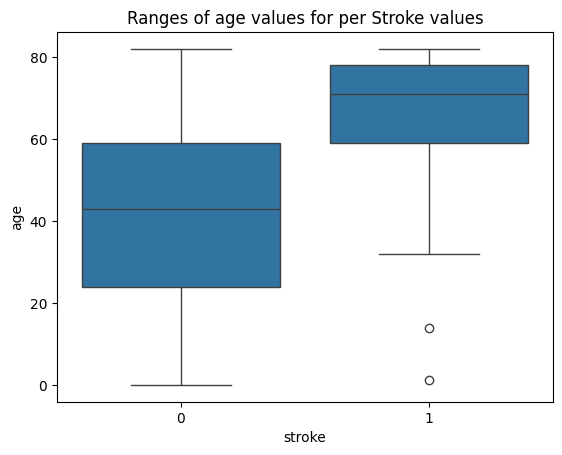

In [ ]:
plt.title("Ranges of age values for per Stroke values")
sns.boxplot(data=dt, x='stroke', y='age')
plt.show()

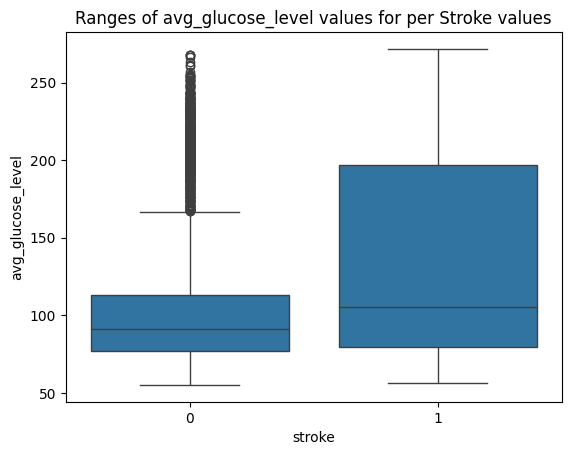

In [ ]:
plt.title("Ranges of avg_glucose_level values for per Stroke values")
sns.boxplot(data=dt, x='stroke', y='avg_glucose_level')
plt.show()

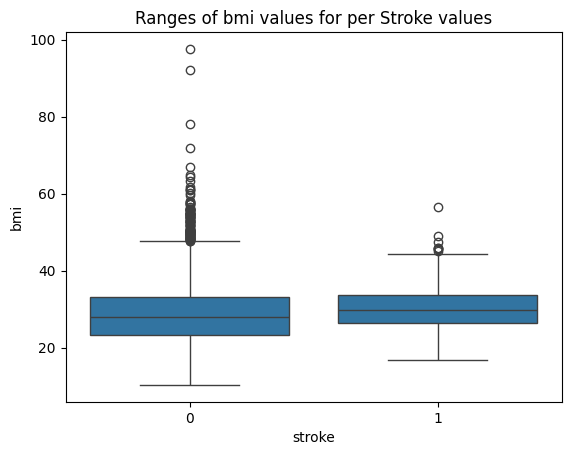

In [ ]:
plt.title("Ranges of bmi values for per Stroke values")
sns.boxplot(data=dt, x='stroke', y='bmi')
plt.show()

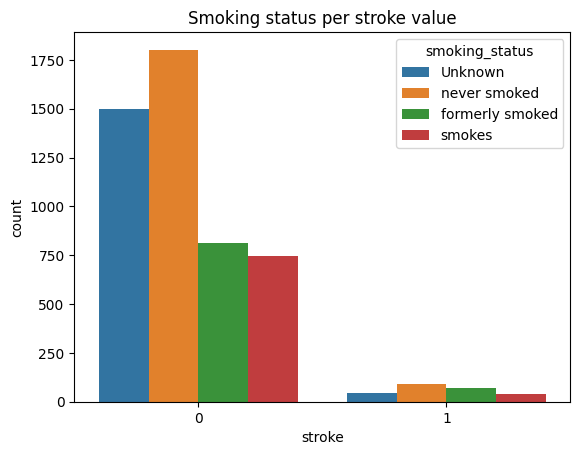

In [ ]:
plt.title("Smoking status per stroke value")
sns.countplot(data=dt, x='stroke', hue='smoking_status')
plt.show()

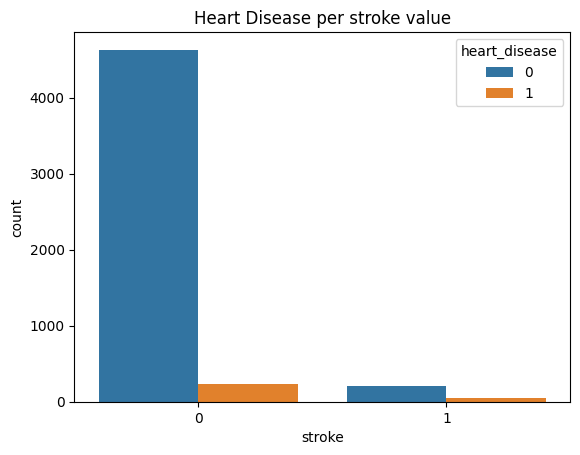

In [ ]:
plt.title("Heart Disease per stroke value")
sns.countplot(data=dt, x='stroke', hue='heart_disease')
plt.show()

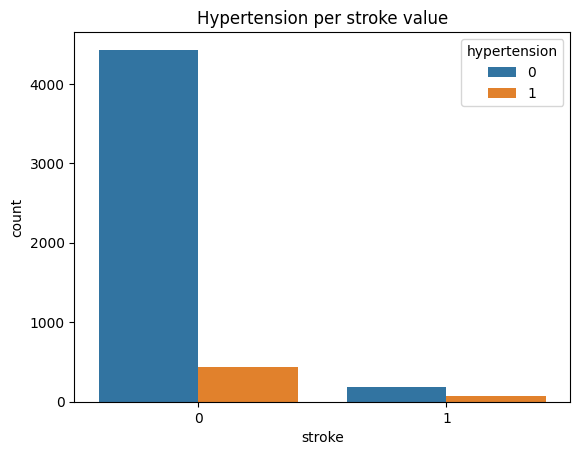

In [ ]:
plt.title("Hypertension per stroke value")
sns.countplot(data=dt, x='stroke', hue='hypertension')
plt.show()

In [ ]:
dt[['age', 'avg_glucose_level', 'bmi', 'stroke']].corr()

,age,avg_glucose_level,bmi,stroke
age,1.000000,0.238171,0.333398,0.245257
avg_glucose_level,0.238171,1.000000,0.175502,0.131945
bmi,0.333398,0.175502,1.000000,0.042374
stroke,0.245257,0.131945,0.042374,1.000000


In [ ]:
dt['bmi'].fillna(dt['bmi'].mean(), inplace=True)

<ipython-input-35-e2ed2d0379be>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dt['bmi'].fillna(dt['bmi'].mean(), inplace=True)


In [ ]:
columnsToRemoveOutliers = ['age', 'avg_glucose_level', 'bmi']

for column in columnsToRemoveOutliers:
  quartile1 = dt[column].quantile(0.25)
  quartile3 = dt[column].quantile(0.75)
  IQR = quartile3 - quartile1

  lower_bound = quartile1 - 1.5 * IQR
  upper_bound = quartile3 + 1.5 * IQR

  dt_no_outliers_iqr = dt[(dt[column] >= lower_bound) & (dt[column] <= upper_bound)]

In [ ]:
dt.drop(['id'], axis=1, inplace=True)
dt_classification = pd.get_dummies(dt, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease'], drop_first=True, dtype=int)

y = dt_classification['stroke']
dt_classification = dt_classification.drop(['stroke'], axis=1)

scaler = StandardScaler()
dt_unsupervised = dt_classification.copy()
dt_unsupervised['age'] = scaler.fit_transform(dt_unsupervised['age'].values.reshape(-1, 1))
dt_unsupervised['avg_glucose_level'] = scaler.fit_transform(dt_unsupervised['avg_glucose_level'].values.reshape(-1, 1))
dt_unsupervised['bmi'] = scaler.fit_transform(dt_unsupervised['bmi'].values.reshape(-1, 1))

In [ ]:
pca = PCA(n_components=5)
pca.fit(dt_classification)
X_classification = pca.transform(dt_classification)

pca = PCA(n_components=5)
pca.fit(dt_unsupervised)
X_unsupervised = pca.transform(dt_unsupervised)

In [ ]:
X_classification_train, X_classification_test, y_classification_train, y_classification_test = train_test_split(X_classification, y, test_size=0.2, random_state=42)
X_unsupervised_train, X_unsupervised_test, y_unsupervised_train, y_unsupervised_test = train_test_split(X_unsupervised, y, test_size=0.2, random_state=42)

X_classification_train = sm.add_constant(X_classification_train)
X_classification_test = sm.add_constant(X_classification_test)

X_unsupervised_train = sm.add_constant(X_unsupervised_train)
X_unsupervised_test = sm.add_constant(X_unsupervised_test)

Accuracy of Logistic Regression on the training data: 0.9241682974559687
Confusion Matrix of Logistic Regression on the training data:
[[3738  163]
 [ 147   40]]
Precision value of Logistic Regression on the training data: 0.19704433497536947
Recall value of Logistic Regression on the training data: 0.21390374331550802
F1 Score value of Logistic Regression on the training data: 0.20512820512820512


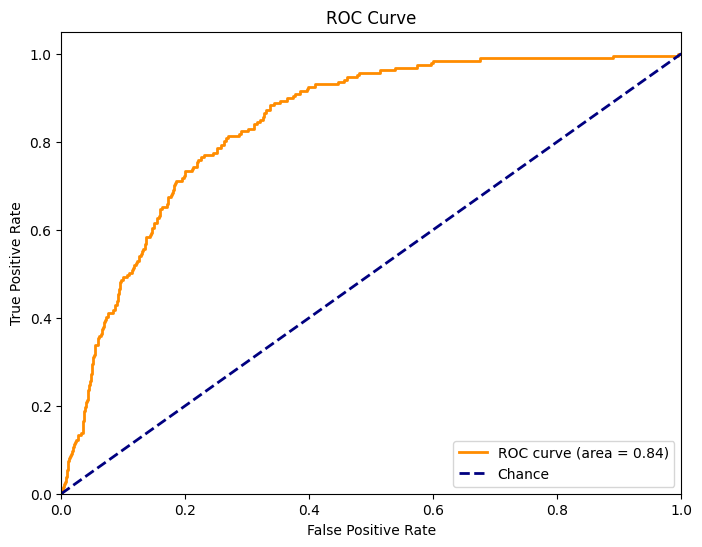



Accuracy of Logistic Regression on the testing data: 0.9207436399217221
Confusion Matrix of Logistic Regression on the testing data:
[[927  33]
 [ 48  14]]
Precision value of Logistic Regression on the testing data: 0.2978723404255319
Recall value of Logistic Regression on the testing data: 0.22580645161290322
F1 Score value of Logistic Regression on the testing data: 0.25688073394495414


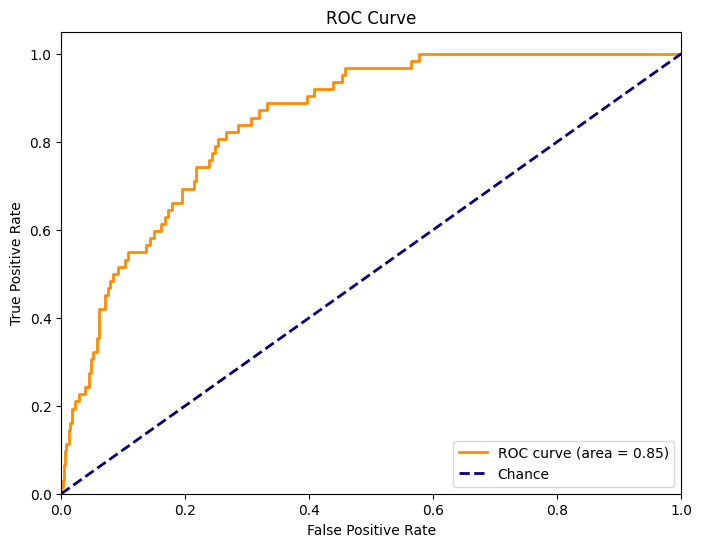

In [ ]:
model = LogisticRegressionCV(class_weight={0: 1, 1: 4.7}, cv=10)
model = model.fit(X_classification_train, y_classification_train)

y_classification_pred = model.predict(X_classification_train)
accuracy = accuracy_score(y_classification_train, y_classification_pred)
print('Accuracy of Logistic Regression on the training data: ' + str(accuracy))
print('Confusion Matrix of Logistic Regression on the training data:\n' + str(confusion_matrix(y_classification_train, y_classification_pred)))
print('Precision value of Logistic Regression on the training data: ' + str(precision_score(y_classification_train, y_classification_pred)))
print('Recall value of Logistic Regression on the training data: ' + str(recall_score(y_classification_train, y_classification_pred)))
print('F1 Score value of Logistic Regression on the training data: ' + str(f1_score(y_classification_train, y_classification_pred)))

y_prob = model.predict_proba(X_classification_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_classification_train, y_prob)
roc_auc = roc_auc_score(y_classification_train, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print('\n')
y_classification_pred = model.predict(X_classification_test)
accuracy = accuracy_score(y_classification_test, y_classification_pred)
print('Accuracy of Logistic Regression on the testing data: ' + str(accuracy))
print('Confusion Matrix of Logistic Regression on the testing data:\n' + str(confusion_matrix(y_classification_test, y_classification_pred)))
print('Precision value of Logistic Regression on the testing data: ' + str(precision_score(y_classification_test, y_classification_pred)))
print('Recall value of Logistic Regression on the testing data: ' + str(recall_score(y_classification_test, y_classification_pred)))
print('F1 Score value of Logistic Regression on the testing data: ' + str(f1_score(y_classification_test, y_classification_pred)))

y_prob = model.predict_proba(X_classification_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_classification_test, y_prob)
roc_auc = roc_auc_score(y_classification_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Accuracy of Logistic Regression on the training data: 0.9273483365949119
[[3748  153]
 [ 144   43]]


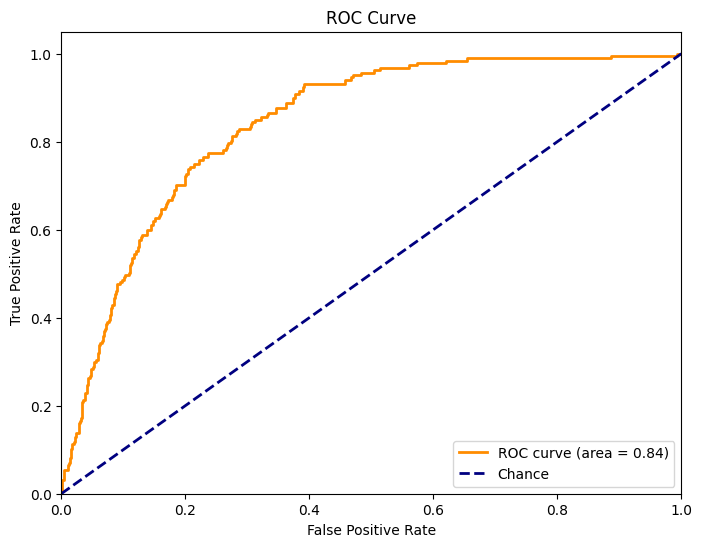

Accuracy of Logistic Regression on the testing data: 0.9187866927592955
[[928  32]
 [ 51  11]]


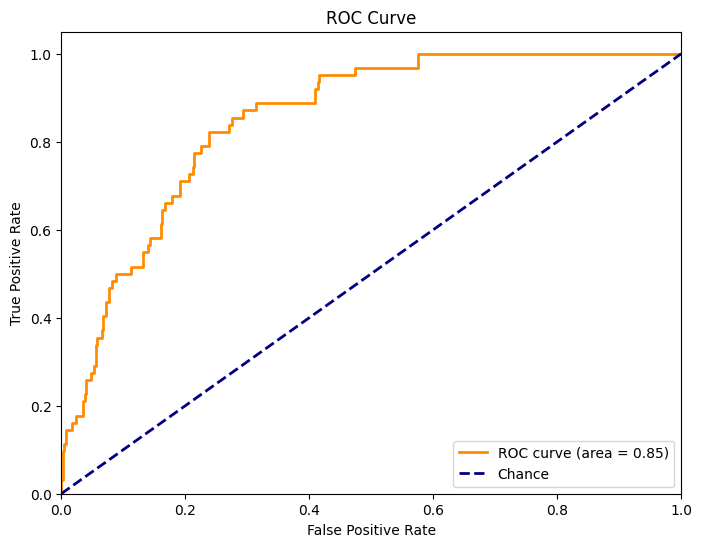

In [ ]:
param_grid = [
    {'penalty':['l1','l2','elasticnet','none'],
    'C' : [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100,1000,2500,5000]
}
]
model = LogisticRegression(class_weight={0: 1, 1: 4.4})
model = model.fit(X_classification_train, y_classification_train)
model = RandomizedSearchCV(model, param_grid, cv = 10, verbose=True, n_jobs=-1)
best_model = model.fit(X_classification_train, y_classification_train)
best_model.best_estimator_
y_classification_pred = best_model.predict(X_classification_train)
accuracy = accuracy_score(y_classification_train, y_classification_pred)
print('Accuracy of Logistic Regression on the training data: ' + str(accuracy))
print(confusion_matrix(y_classification_train, y_classification_pred))

y_prob = best_model.predict_proba(X_classification_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_classification_train, y_prob)
roc_auc = roc_auc_score(y_classification_train, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

y_classification_pred = best_model.predict(X_classification_test)
accuracy = accuracy_score(y_classification_test, y_classification_pred)
print('Accuracy of Logistic Regression on the testing data: ' + str(accuracy))
print(confusion_matrix(y_classification_test, y_classification_pred))

y_prob = best_model.predict_proba(X_classification_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_classification_test, y_prob)
roc_auc = roc_auc_score(y_classification_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_unsupervised_train)

y_unsupervised_pred = kmeans.predict(X_unsupervised_train)
print('Silhouette Score for K-means clustering on the unsupervised training data: ' + str(silhouette_score(X_unsupervised_train, y_unsupervised_pred)))
accuracy = accuracy_score(y_unsupervised_train, y_unsupervised_pred)
print('Accuracy of K-means on the unsupervised testing data: ' + str(accuracy))
print(confusion_matrix(y_unsupervised_train, y_unsupervised_pred))

y_unsupervised_pred = kmeans.predict(X_unsupervised_test)
print('Silhouette Score for K-means clustering on the unsupervised testing data: ' + str(silhouette_score(X_unsupervised_test, y_unsupervised_pred)))
accuracy = accuracy_score(y_unsupervised_test, y_unsupervised_pred)
print('Accuracy of K-means on the unsupervised testing data: ' + str(accuracy))
print(confusion_matrix(y_unsupervised_test, y_unsupervised_pred))
print('\n')

dbscan = DBSCAN(eps=2, min_samples=2)
dbscan.fit(X_unsupervised_train)

print('Number of clusters from DBSCAN: ' + str(len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)))

y_unsupervised_pred = dbscan.fit_predict(X_unsupervised_train)
print('Silhouette Score for DBSCAN clustering on the unsupervised training data: ' + str(silhouette_score(X_unsupervised_train, y_unsupervised_pred)))
accuracy = accuracy_score(y_unsupervised_train, y_unsupervised_pred)
print('Accuracy of DBSCAN on the unsupervised training data: ' + str(accuracy))

y_unsupervised_pred = dbscan.fit_predict(X_unsupervised_test)
print('Silhouette Score for DBSCAN clustering on the unsupervised testing data: ' + str(silhouette_score(X_unsupervised_test, y_unsupervised_pred)))
accuracy = accuracy_score(y_unsupervised_test, y_unsupervised_pred)
print('Accuracy of DBSCAN on the unsupervised testing data: ' + str(accuracy))

Silhouette Score for K-means clustering on the unsupervised training data: 0.2564142932130042
Accuracy of K-means on the unsupervised testing data: 0.5961350293542075
[[2431 1470]
 [ 181    6]]
Silhouette Score for K-means clustering on the unsupervised testing data: 0.28391481476996805
Accuracy of K-means on the unsupervised testing data: 0.5831702544031311
[[596 364]
 [ 62   0]]


Number of clusters from DBSCAN: 2
Silhouette Score for DBSCAN clustering on the unsupervised training data: 0.6114978575089516
Accuracy of DBSCAN on the unsupervised training data: 0.9535225048923679
Silhouette Score for DBSCAN clustering on the unsupervised testing data: 0.5865609657190487
Accuracy of DBSCAN on the unsupervised testing data: 0.9383561643835616
